In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes.utils import summary_data_from_transaction_data

In [55]:
customer_df = pd.read_csv('../data/customers.csv', parse_dates=["signup_date"])
print(customer_df.head(10))

  customer_id signup_date  true_lifetime_days
0      C00000  2025-08-22                 204
1      C00001  2025-03-07                 365
2      C00002  2025-08-18                  48
3      C00003  2025-09-22                  84
4      C00004  2025-05-28                 113
5      C00005  2025-11-12                 120
6      C00006  2025-08-22                 117
7      C00007  2025-08-03                 321
8      C00008  2025-05-02                 209
9      C00009  2025-01-06                 172


In [56]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         3000 non-null   object        
 1   signup_date         3000 non-null   datetime64[ns]
 2   true_lifetime_days  3000 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 70.4+ KB


In [57]:
transaction_df = pd.read_csv('../data/transactions.csv', parse_dates=["transaction_date"])
print(transaction_df.head(10))

  customer_id transaction_date  amount
0      C00000       2025-09-10  195.78
1      C00000       2025-09-12   50.87
2      C00000       2025-10-01  133.25
3      C00000       2025-10-16   37.44
4      C00000       2025-10-18  101.95
5      C00000       2025-10-28  195.22
6      C00000       2025-11-23  206.80
7      C00000       2025-11-27   79.74
8      C00000       2025-12-09   85.42
9      C00000       2025-12-27   47.99


In [58]:
transaction_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46704 entries, 0 to 46703
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       46704 non-null  object        
 1   transaction_date  46704 non-null  datetime64[ns]
 2   amount            46704 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.1+ MB


In [59]:
txn_summary = pd.read_csv("../data/transaction_summary.csv", index_col=0)
txn_summary.rename(columns={"T": "tenure"}, inplace=True)

# latent churn risk
risk_score = (
    -0.01 * txn_summary["tenure"],
    -0.02 * txn_summary["frequency"],
    -0.003 * txn_summary["monetary_value"]
)

baseline_hazard = 0.005
hazard = baseline_hazard * np.exp(risk_score)

# End of calibration time
observation_end = pd.Timestamp("2025-11-01")

# Calculate censor_time and reindex to match txn_summary order
censor_time_series = (transaction_df.groupby("customer_id")
                                    .apply(lambda x: (observation_end - x["transaction_date"]).min(), include_groups=False)
                                    .dt.days
                                    .astype(int)
                                    .reindex(txn_summary.index)) # value only in transaction_df value is dropped

txn_summary["censor_time"] = censor_time_series

# Calculate churn_time and reindex to match txn_summary order
churn_time_series = (transaction_df.groupby("customer_id")
                                  .apply(lambda x: x["transaction_date"].max() - x["transaction_date"].min(), include_groups=False)
                                  .dt.days
                                  .astype(int)
                                  .reindex(txn_summary.index)) # # value only in transaction_df value is dropped

txn_summary["churn_time"] = churn_time_series

# Time to event
txn_summary["T"] = np.minimum(txn_summary["censor_time"], txn_summary["churn_time"])
txn_summary["E"] = (txn_summary["churn_time"] <= txn_summary["censor_time"]).astype(int)
print(txn_summary.head(10))

             frequency  recency  tenure  monetary_value  \
customer_id                                               
C00000             5.0     48.0    52.0      103.746000   
C00001            12.0    204.0   229.0       57.735000   
C00002             9.0     37.0    73.0       86.307778   
C00003             1.0      1.0    28.0       23.150000   
C00004            17.0     98.0   146.0      109.965882   
C00006             1.0     34.0    58.0       38.160000   
C00007             4.0     50.0    82.0       88.840000   
C00008            12.0    176.0   177.0       56.019167   
C00009            17.0    163.0   298.0       95.345294   
C00010             1.0      4.0    31.0       15.720000   

             expected_purchases_60d  probability_alive  probability_alive_60d  \
customer_id                                                                     
C00000                     4.918454           0.933728               0.156999   
C00001                     2.666590           0.

# Churn with Survival Analysis
Time-to-churn modeling

Yêu cầu

● Define duration & event

● Fit CoxPH / Weibull

● Predict:
○ Survival curve
○ Expected remaining lifetime

## Kaplan-Meier Estimator
* **Meaning**: “If I randomly pick one individual from the dataset, what is the probability they are still active (not churned) after t days?”

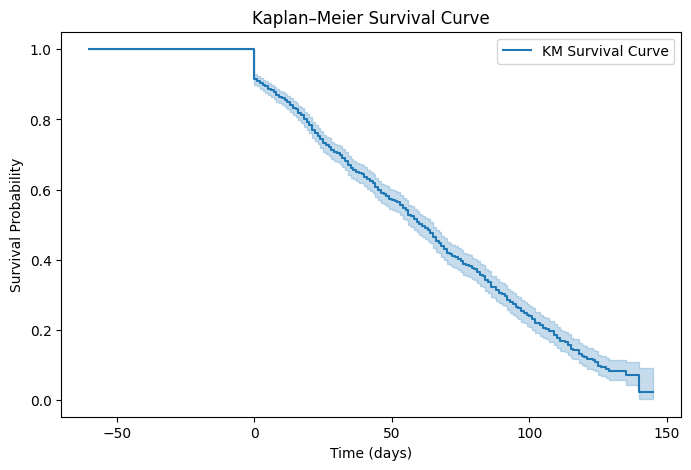

In [69]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 5))
kmf.fit(txn_summary["T"], event_observed=txn_summary["E"], label="KM Survival Curve")
kmf.plot()
plt.title("Kaplan–Meier Survival Curve")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.show()


## Cox Proportional Hazards Model (lifelines)

In [92]:
from lifelines import CoxPHFitter

features = ["tenure", "frequency", "monetary_value"]
cph = CoxPHFitter()

cph.fit(
    txn_summary[features + ["T", "E"]],
    duration_col="T",
    event_col="E"
)

cph.print_summary()

# Coefficients :
# - coef < 0 → feature giúp giảm hazard (giữ user lâu hơn)
# - exp(coef) = hazard ratio

<lifelines.CoxPHFitter: fitted with 2544 total observations, 1708 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 2544
number of events observed = 836
   partial log-likelihood = -4874.62
         time fit was run = 2026-01-19 15:14:52 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
tenure         -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
frequency      -0.16      0.85      0.01           -0.18           -0.14                0.84                0.87
monetary_value -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

                cmp to      z      p  -log2(p)
covariate                                     
tenure            0.00 -10.08 <0.005     76.93
frequency         0.00 -18.07 <0.005    240.14
monetary_value    0.00  -3.63 <0.005     11.76
---
Concordance = 0.83
Partial AIC = 9755.23
log-likelihood ratio test = 833.97 on 3 df
-log2(p) of ll-ratio test = 597.06

## Expected Remaining Lifetime

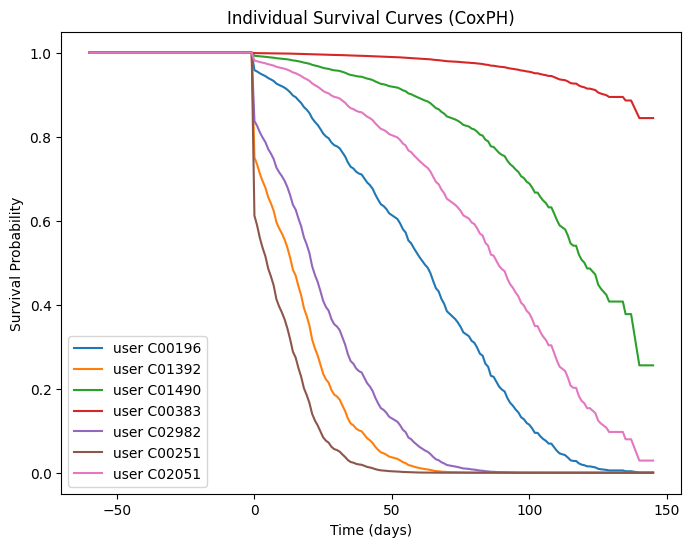

In [129]:
sample_users = txn_summary.sample(7, random_state=10).reset_index()

plt.figure(figsize=(8, 6))

for _, row in sample_users.iterrows():
    surv_fn = cph.predict_survival_function(row[features].to_frame().T)
    # Visualization 
    plt.plot(surv_fn.index, surv_fn.values.flatten(), label=f"user {row.customer_id}")

plt.title("Individual Survival Curves (CoxPH)")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

In [133]:
expected_user_lifetime = []

for _, row in txn_summary.iterrows():
    surv_fn = cph.predict_survival_function(row[features].to_frame().T)
    # Time Points and Survival Probs from survival function
    times = surv_fn.index
    survival_probs = np.array(surv_fn.iloc[:, 0].values) 
    # Integral using trapezoidal rule
    expected_lifetime = np.trapezoid(survival_probs, times)
    expected_user_lifetime.append(expected_lifetime)

txn_summary["e_lifetime"] = expected_user_lifetime

txn_summary

,frequency,recency,tenure,monetary_value,expected_purchases_60d,probability_alive,probability_alive_60d,is_churn_60d,censor_time,churn_time,T,E,e_lifetime
customer_id,,,,,,,,,,,,,
C00000,5.0,48.0,52.0,103.746000,4.918454,0.933728,1.569986e-01,False,-60,112,-60,0,90.681252
C00001,12.0,204.0,229.0,57.735000,2.666590,0.844744,2.092759e-01,False,-49,278,-49,0,150.163061
C00002,9.0,37.0,73.0,86.307778,0.453632,0.071875,2.854796e-04,True,36,37,36,0,108.751617
C00003,1.0,1.0,28.0,23.150000,1.915502,0.558279,1.029677e-01,False,-17,45,-17,0,72.364510
C00004,17.0,98.0,146.0,109.965882,0.199286,0.032318,8.713614e-05,True,48,98,48,0,162.901055
...,...,...,...,...,...,...,...,...,...,...,...,...,...
C02994,16.0,102.0,272.0,90.350000,0.000010,0.000003,1.036654e-07,True,170,102,102,1,177.304942
C02995,2.0,9.0,9.0,21.300000,7.131484,0.952923,1.518673e-01,False,-60,69,-60,0,72.847283
C02996,6.0,113.0,134.0,71.610000,2.524249,0.870196,3.276538e-01,False,-27,161,-27,0,104.965366


## Expected Remaining Lifetime

In [123]:
# Time Points and Survival Probs from survival function
times = surv_fn.index
survival_probs = np.array(surv_fn.iloc[:, 0].values) 

# Integral using trapezoidal rule
expected_lifetime = np.trapz(survival_probs, times)
print(f"Expected Lifetime: {expected_lifetime}")

# Median Survival Time 
# median_survival = cph.predict_median(new_subject_covariates)


Expected Lifetime: 143.64340303717051


C:\Users\Admin\AppData\Local\Temp\ipykernel_24492\1449141203.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  expected_lifetime = np.trapz(survival_probs, times)
